<table align="left">
  <td>
    <a href="https://is.gd/5i8EAi" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
</table>

# Clasificador - conjunto de datos CIFAR-10 - Experimentos

Se utilizará una **red neuronal convolucional** para clasificar imágenes de 32x32x3 (RGB) en 10 clases.

El conjunto de datos CIFAR-10 consta de 60000 imágenes en color de 32x32 en 10 clases, con 6000 imágenes por clase. Hay 50000 imágenes de entrenamiento y 10000 de prueba.

El conjunto de datos se divide en cinco lotes de entrenamiento y un lote de prueba, cada uno con 10000 imágenes. 
- El lote de prueba contiene exactamente 1000 imágenes seleccionadas al azar de cada clase. 
- Los lotes de entrenamiento contienen el resto de imágenes en orden aleatorio, pero algunos lotes de entrenamiento pueden contener más imágenes de una clase que de otra. Entre ellos, los lotes de entrenamiento contienen exactamente 5000 imágenes de cada clase.

Referencias: https://www.cs.toronto.edu/~kriz/cifar.html

<a href="https://imgbb.com/"><img src="https://i.ibb.co/SXtPQzj/CIFAR10.png" alt="CIFAR10" border="0"></a>

Este notobook se utilizará como base para realizar los siguientes experimentos:

- Experimento 1: Estructura VGG1
- Experimento 2: Estructura VGG2
- Experimento 3: Estructura VGG3
- Experimento 4: Estructura VGG3 + Dropout (0.2)
- Experimento 5: Estructura VGG3 + Dropout (0.5)
- Experimento 6: Estructura VGG3 + Batch Normalization
- Experimento 7: Estructura VGG3 + Batch Normalization + Dropout (0.2)
- Experimento 8: Estructura VGG3 + Batch Normalization + Data Augmentation

## **Paso 1.** Importar las librerías necesarias 

In [29]:
import tensorflow as tf
from tensorflow import keras
# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D, BatchNormalization
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras_preprocessing.image import ImageDataGenerator
from keras.models import load_model 
from keras.constraints import maxnorm
from tensorflow.keras.optimizers import SGD
from keras.utils import np_utils
from keras import backend as K 
K.set_image_data_format('channels_last')

# to make this notebook's output stable across runs
np.random.seed(42)
import Modelos_Exp_CNN as cnnexp

## **Paso 2.** Cargar el conjunto de datos CIFAR-10

Se cargan los datos de entrenamiento y prueba y se escala la intensidad de los píxeles en el rango de 0-1 y se convierten en flotantes, dividiéndolos por 255.


In [30]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()
#normalizing inputs from 0-255 to 0.0-1.0 
X_train_full = X_train_full.astype('float32') 
X_test = X_test.astype('float32') 
X_train_full = X_train_full / 255.0 
X_test = X_test / 255.0

In [31]:
X_train_full.shape

(50000, 32, 32, 3)

Se Divide el conjunto de entrenamiento completo en un subconjunto de validación y un subconjunto de entrenamiento (más pequeño).

![Split Data](https://806230.smushcdn.com/1739487/wp-content/uploads/2021/04/train-and-test-1-min-1.png )

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split((X_train_full),y_train_full, test_size=0.1)

### **Paso 2.1.** Visualizar las imágenes del conjunto de datos

In [33]:
# initialize the label names for the CIFAR-10 dataset
class_names = ["airplane", "automobile", "bird", "cat", "deer",
	"dog", "frog", "horse", "ship", "truck"]
print(class_names[y_train[0][0]])

cat


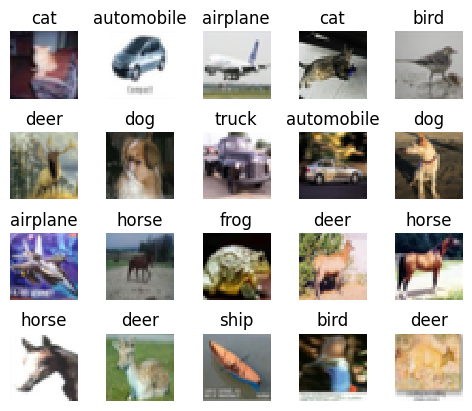

In [34]:
n_rows = 4
n_cols = 5
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index][0]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

plt.show()

### Data Augmentation

Dado que el conjunto de datos se compone de pequeñas fotos de objetos, no queremos utilizar aumentos que distorsionen demasiado las imágenes, para poder conservar y utilizar las características útiles de las mismas.

Los tipos de aumentos aleatorios que se utilizarán son:: 
 - giro horizontal, 
 - desplazamientos del 10% en la altura y la anchura de la imagen.

In [35]:
# create data generator
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
# prepare iterator - DA_train = data augmentation x_train, y_train
DA_train = datagen.flow(X_train, y_train, batch_size=64)

## **Paso 3.** Creación del modelo.

En la siguiente imagen se muestran las tres estructuras bases de la red neuronal convolucional que se utilizaran para resolver el problema de clasificación de imágenes de ropa.

<a href="https://ibb.co/fqQqYcX"><img src="https://i.ibb.co/GnFnvhd/imagen-2022-11-05-223615366.png" alt="experimentos" border="0" width="500" height="250"></a>

### Lista de Experimentos a Realizar
- Experimento 1: Estructura VGG1
- Experimento 2: Estructura VGG2
- Experimento 3: Estructura VGG3
- Experimento 4: Estructura VGG3 + Dropout (0.2)
- Experimento 5: Estructura VGG3 + Dropout (0.5)
- Experimento 6: Estructura VGG3 + Batch Normalization
- Experimento 7: Estructura VGG3 + Batch Normalization + Dropout (0.2)
- Experimento 8: Estructura VGG3 + Batch Normalization + Data Augmentation

In [36]:
np.random.seed(42)
tf.random.set_seed(42)

In [37]:
## Modelo Secuencial Keras
keras.backend.clear_session()
model = Sequential()

In [38]:
## Función creada para seleccionar el modelo
## parametro 1: modelo keras
## parametro 2: "mnist" o "cifar10"
## Num Experimento: 1 - 8
model, exp_name = cnnexp.select_exp(model,"cifar10", 2)

Experimento:  2


In [39]:
input_shape = X_train.shape  
model.build(input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0

## **Paso 4.** Compilando el modelo y entrenando el modelo. 


*   **loss**: "sparse_categorical_crossentropy", se utiliza está función dado que se cuenta con un número de etiquetas escasas (sparse) - no binarias.
*   **optimizer** = Adam. 
*   **metrics**: Exactitud (accuracy)

In [40]:
# Compile model 
model.compile(loss="sparse_categorical_crossentropy",optimizer="adam",metrics=["accuracy"])

### 4.1 Callbacks - Guardar el mejor modelo durante el entrenamiento

- Al utilizar datos de validación durante el entrenamiento es posible salvar el ultimo mejor modelo.
- Actualizar la variable exp_name con el nombre del experimento a realizar.

In [41]:
if exp_name == "Exp_8" or exp_name == "Exp_9":
    # Tensorflow savemodel format
    best_model_name = "Trained_Models/cifar10_model_" + exp_name
else:
    best_model_name = "Trained_Models/cifar10_model_" + exp_name + ".h5"
print(best_model_name)

Trained_Models/cifar10_model_Exp_2.h5


In [42]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(best_model_name, save_best_only=True)

In [15]:
if exp_name == "Exp_8" or exp_name == "Exp_9":
    # Fit the model on the batches generated by datagen.flow().
    print("Entrenando modelo" + exp_name + " Con Data Augmentation") 
    steps = int(X_train.shape[0] / 64)
    history = model.fit(DA_train, steps_per_epoch=steps, epochs=100, validation_data=(X_valid, y_valid), callbacks=[checkpoint_cb], verbose=0)
else:
    print("Entrenando modelo " + exp_name + " sin data augmentation") 
    history = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_data=(X_valid, y_valid), callbacks=[checkpoint_cb], verbose=0)

Entrenando modelo Exp_1 sin data augmentation


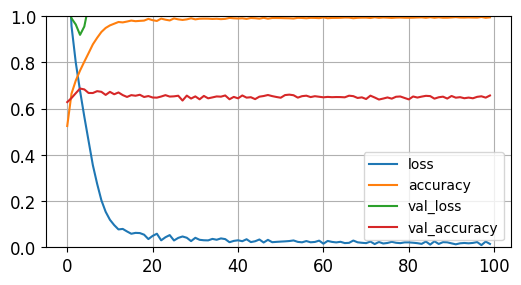

In [16]:
# se utiliza pandas para visualizar la información almacenada en el diccionario de historia de entrenamiento y graficarla. 
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(6, 3))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## **Paso 5.** Evaluación del modelo. 
Se evalua el modelo con el conjunto de datos de prueba.

- X_train: Conjunto de datos de entrenamiento.
- y_train: Etiquetas de los datos de entrenamiento.
- X_valid: Conjunto de datos de validación.
- y_valid: Etiquetas de los datos de validación.
- X_test: Conjunto de datos de prueba.
- y_test: Etiquetas de los datos de prueba.

In [17]:
model = load_model(best_model_name)

In [18]:
scores_train = model.evaluate(X_train, y_train)
scores_valid = model.evaluate(X_valid, y_valid)
scores_test = model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.9545 - accuracy: 0.6824


In [19]:
print('train loss:', round(scores_train[0]*100,2), '%')
print('valid loss:', round(scores_valid[0]*100,2), '%')
print('test loss:', round(scores_test[0]*100,2), '%')
print("\n")
print('train accuracy:', round(scores_train[1]*100,2), '%')
print('valid accuracy:', round(scores_valid[1]*100,2), '%')
print('test accuracy:', round(scores_test[1]*100,2), '%')

train loss: 51.18 %
valid loss: 91.96 %
test loss: 95.45 %


train accuracy: 83.16 %
valid accuracy: 68.72 %
test accuracy: 68.24 %


## **Paso 6.** Usando el modelo para hacer predicciones. 

Se toman 5 instancias del set de prueba para hacer la predicción. y se imprime la matriz de probabilidad para cada una de las instancias. 

In [23]:
X_new = X_test[10:15]
y_proba = model.predict(X_new)

Visualizar las predicciones

In [24]:
classes_x = np.argmax(y_proba,axis=1)
np.array(class_names)[classes_x]

array(['airplane', 'truck', 'dog', 'horse', 'truck'], dtype='<U10')

Visualizar los valores reales

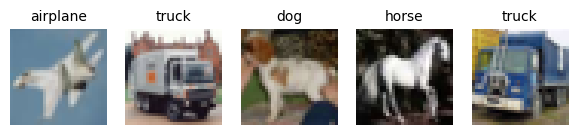

In [28]:
y_new = y_test[10:15]
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 5, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_new[index][0]], fontsize=10)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()